In [1]:
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.regularizers import l2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from itertools import islice
from collections import OrderedDict

from preprocessing.numeric import *
from preprocessing.tokens import *

RANDOM_SEED = 2
tf.random.set_seed(RANDOM_SEED)

tf.__version__, tf.keras.__version__

('2.2.0', '2.3.0-tf')

In [2]:
train = tf.data.experimental.make_csv_dataset("data/train.tsv",
                                           field_delim="\t",
                                           batch_size=1000,
#                                            compression_type="GZIP",
                                           label_name="Click",
                                           num_epochs=1)

test = tf.data.experimental.make_csv_dataset("data/test.tsv",
                                           field_delim="\t",
                                           batch_size=1_000,
                                           label_name="Click",
                                           num_epochs=1)

NUMERIC_FEATURES = ["Depth", "Position", "Age", "UserID", "AdvertiserId"]
CATEGORICAL_FEATURES = ["Gender"]
TOKENS_FEATURES = ["AdKeyword_tokens", "AdTitle_tokens", "AdDescription_tokens", "Query_tokens"]
ID_FEATURES = ["AdId_hashed", "AdvertiserId_hashed", "UserID_hashed"]

---
#### Numeric features

In [3]:
GENDER_SIZE = 2
N_HASHING_BINS = 1_000

train = train\
    .map(PackNumericFeatures(NUMERIC_FEATURES))\
    .map(Normalize(NUMERIC_FEATURES))\
    .map(Categorize("Gender", GENDER_SIZE))\
    .map(FeatureHash("AdId"), N_HASHING_BINS)\
    .map(FeatureHash("AdvertiserId"), N_HASHING_BINS)\
    .map(FeatureHash("UserID"), N_HASHING_BINS)

test = test\
    .map(PackNumericFeatures(NUMERIC_FEATURES))\
    .map(Normalize(NUMERIC_FEATURES))\
    .map(Categorize("Gender", GENDER_SIZE))\
    .map(FeatureHash("AdId"), N_HASHING_BINS)\
    .map(FeatureHash("AdvertiserId"), N_HASHING_BINS)\
    .map(FeatureHash("UserID"), N_HASHING_BINS)

---
#### Sequence of tokens features
AdKeyword_tokens, AdTitle_tokens, AdDescription_tokens, Query_tokens

Jak stworzyć słownik do modelu?

In [4]:
n_words = {
    "AdKeyword_tokens": 5_000,
    "AdTitle_tokens": 5_000,
    "AdDescription_tokens": 5_000,
    "Query_tokens": 9_000
}

max_length = {
    "AdKeyword_tokens": 6,
    "AdTitle_tokens": 14,
    "AdDescription_tokens": 30,
    "Query_tokens": 7
}

vocab_path = {
    "AdKeyword_tokens": "data/vocab/AdKeyword_tokens.txt",
    "AdTitle_tokens": "data/vocab/AdTitle_tokens.txt",
    "AdDescription_tokens": "data/vocab/AdDescription_tokens.txt",
    "Query_tokens": "data/vocab/Query_tokens.txt"
}

OOV_WORDS = 500

for name in TOKENS_FEATURES:
    train = train.map(TokenizeWithVocabFile(name, vocab_size=n_words[name], max_length=max_length[name], vocab_file=vocab_path[name], oov_buckets=OOV_WORDS))
    test = test.map(TokenizeWithVocabFile(name, vocab_size=n_words[name], max_length=max_length[name], vocab_file=vocab_path[name], oov_buckets=OOV_WORDS))

---
#### Model

In [8]:
EMBEDDING_DIM = 32
ID_EMBEDDING_DIM = 32

### Numeric and simple categorical
x_num_input = tf.keras.Input(shape=(len(NUMERIC_FEATURES), ), name="numeric")
x_gender_input = tf.keras.Input(shape=(GENDER_SIZE, ), name="Gender")
x_num = tf.keras.layers.Concatenate()([x_gender_input, x_num_input])
x_num = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=l2(0.001))(x_num)

### Ids
# Ad
x_ad_input = tf.keras.Input(shape=(1, ), name="AdId_hashed")
ad_embedding = tf.keras.layers.Embedding(N_HASHING_BINS, ID_EMBEDDING_DIM)
x_ad = ad_embedding(x_ad_input)
x_ad = tf.keras.layers.Reshape((ID_EMBEDDING_DIM, ))(x_ad)
x_ad = tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=l2(0.001))(x_ad)

# Advertiser
x_advertiser_input = tf.keras.Input(shape=(1, ), name="AdvertiserId_hashed")
advertiser_embedding = tf.keras.layers.Embedding(N_HASHING_BINS, ID_EMBEDDING_DIM)
x_advertiser = advertiser_embedding(x_advertiser_input)
x_advertiser = tf.keras.layers.Reshape((ID_EMBEDDING_DIM, ))(x_advertiser)
x_advertiser = tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=l2(0.001))(x_advertiser)

# UserId
x_user_input = tf.keras.Input(shape=(1, ), name="UserID_hashed")
user_embedding = tf.keras.layers.Embedding(N_HASHING_BINS, ID_EMBEDDING_DIM)
x_user = user_embedding(x_user_input)
x_user = tf.keras.layers.Reshape((ID_EMBEDDING_DIM, ))(x_user)
x_user = tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=l2(0.001))(x_user)

### Tokens
embeddings = []
embedding_inputs = []
for name in TOKENS_FEATURES:
    embedding_layer = tf.keras.layers.Embedding(input_dim=n_words[name] + OOV_WORDS, 
                                                output_dim=EMBEDDING_DIM, 
                                                mask_zero=True, 
                                                input_length=max_length[name])
    x_emb_input = tf.keras.Input(shape=(max_length[name]), name=name)  # model doesn't work with ragged tensor
    embedding_inputs.append(x_emb_input)  # appending to inputs
    x_emb = embedding_layer(x_emb_input)
#     x_emb = tf.keras.layers.Conv1D(64, kernel_size=3, kernel_regularizer=l2(0.01), use_bias=False)(x_emb)
#     x_emb = tf.keras.layers.BatchNormalization()(x_emb)
#     x_emb = tf.keras.layers.Dropout(0.5)(x_emb)
#     x_emb = tf.keras.layers.GlobalMaxPool1D()(x_emb)
    x_emb = tf.keras.layers.LSTM(32, activation="relu", dropout=0.5, kernel_regularizer=l2(0.001))(x_emb)
    embeddings.append(x_emb)

x = tf.keras.layers.Concatenate(axis=-1)([x_num, x_ad, x_advertiser, x_user, *embeddings])

feedforward = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu", use_bias=False, kernel_regularizer=l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid", name="prediction"),
])

output = feedforward(x)

model = tf.keras.Model(inputs=[x_num_input, x_gender_input, x_ad_input, x_advertiser_input, x_user_input, *embedding_inputs], outputs=output, name="Adclick")

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

In [9]:
model.summary()

Model: "Adclick"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
AdId_hashed (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
AdvertiserId_hashed (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
UserID_hashed (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
Gender (InputLayer)             [(None, 2)]          0                                            
____________________________________________________________________________________________

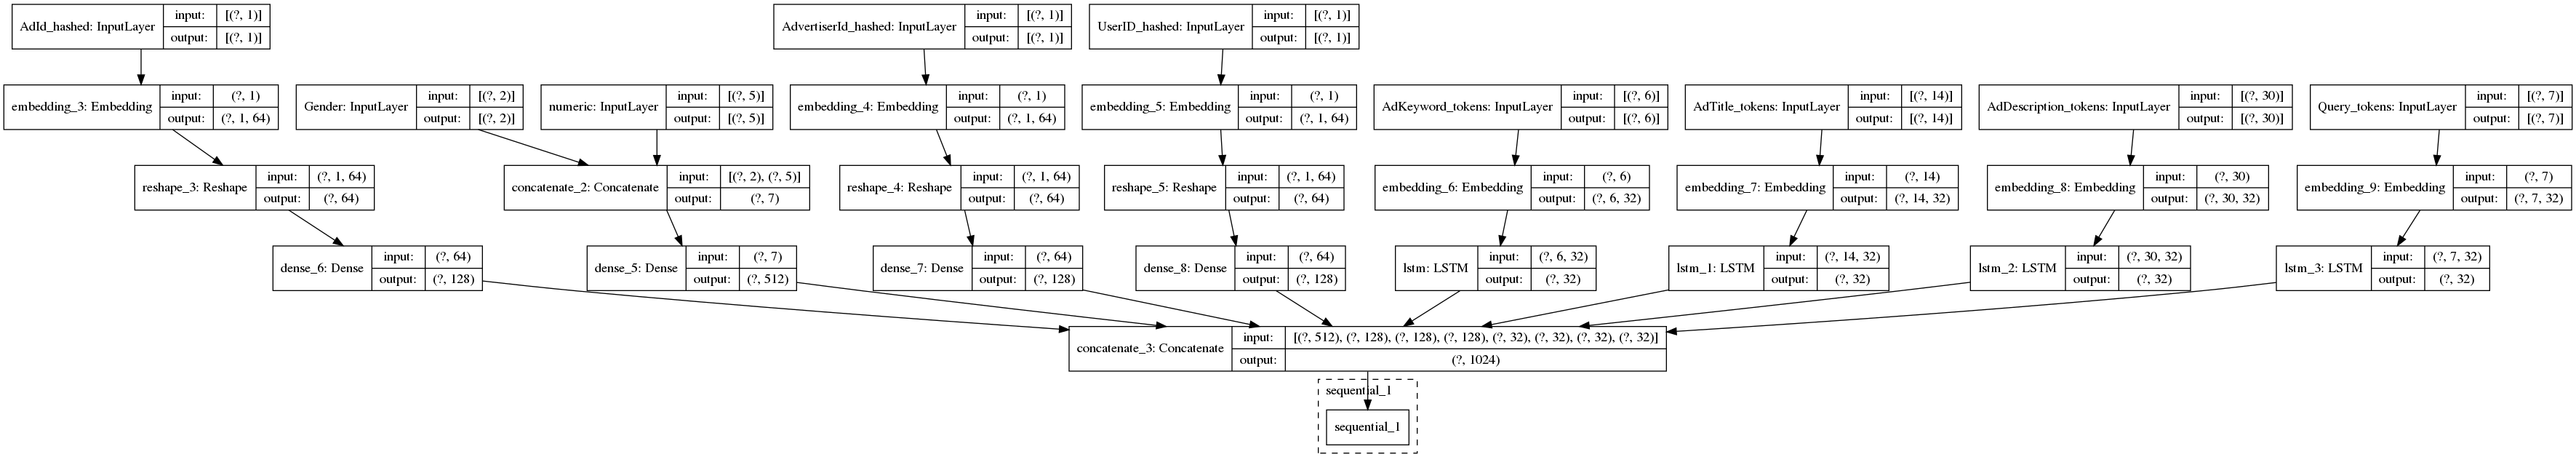

In [10]:
tf.keras.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [11]:
def schedule(epoch, lr):
    print(epoch)
    if epoch == 0:
        return 0.01
    elif epoch == 1:
        return 0.001
    elif epoch == 2:
        return 0.0001
    else:
        return 0.00001
scheduler = tf.keras.callbacks.LearningRateScheduler(schedule, verbose=1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='models/model_id_embedding_10M.{epoch:02d}-{val_auc:.4f}_val_auc.h5')

history = model.fit(train, validation_data=test, epochs=4, callbacks=[scheduler, checkpointer])

0

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/4
10000/10000 [==============================] - 1350s 135ms/step - loss: 0.1816 - accuracy: 0.9528 - auc: 0.7032 - val_loss: 0.1814 - val_accuracy: 0.9523 - val_auc: 0.7107 - lr: 0.0100
1

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/4
10000/10000 [==============================] - 1348s 135ms/step - loss: 0.1721 - accuracy: 0.9531 - auc: 0.7349 - val_loss: 0.1761 - val_accuracy: 0.9524 - val_auc: 0.7225 - lr: 0.0010
2

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 3/4
10000/10000 [==============================] - 1310s 131ms/step - loss: 0.1712 - accuracy: 0.9532 - auc: 0.7391 - val_loss: 0.1748 - val_accuracy: 0.9525 - val_auc: 0.7263 - lr: 1.0000e-04
3

Epoch 00004: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 4/4
10000/10000 [==============================] - 1372s 137ms/step - loss: 0.1710 - accuracy: 0.9531 - auc: 0.7393 - val

# Making predictions

In [16]:
final = tf.data.experimental.make_csv_dataset("data/D5M_test_x.tsv.gz",
                                           field_delim="\t",
                                           batch_size=10_000,
                                           compression_type="GZIP",
                                           label_name="Click",
                                           num_epochs=1,
                                           column_defaults=[tf.int32, tf.string, *[tf.int32 for _ in range(7)], *[tf.string for _ in range(4)]]
                                           )
final = final\
    .map(PackNumericFeatures(NUMERIC_FEATURES))\
    .map(Normalize(NUMERIC_FEATURES))\
    .map(Categorize("Gender", GENDER_SIZE))

for name in TOKENS_FEATURES:
    final = final.map(TokenizeWithVocabFile(name, vocab_size=n_words[name], max_length=max_length[name], vocab_file=vocab_path[name], oov_buckets=OOV_WORDS))

In [17]:
preds = model.predict(final)

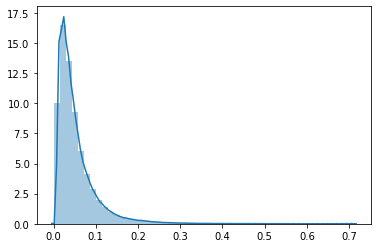

In [18]:
import seaborn as sns
sns.distplot(preds)

In [19]:
model.evaluate(test)

100/100 [==============================] - 32s 320ms/step - loss: 0.1745 - accuracy: 0.9525 - auc: 0.7298


[0.17450663447380066, 0.952468991279602, 0.7297556400299072]

In [26]:
prediction_strings = ["Przemyslaw Kaleta\n"] + [str(num) + "\n" for num in preds[:,0]]
with open("data/kaletap_submission_lstm.txt", "w") as submission_file:
    submission_file.writelines(prediction_strings)